In [1]:
####MLP algorithm implementation
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  
from IPython.display import display

# Step 1: Load the data
file_path = "/kaggle/input/diabetes_012_health_indicators_BRFSS2015.csv"
data = pd.read_csv(file_path)

# Print the column names
print("Dataset Column Names:")
print(data.columns)

# Step 2: Data preprocessing
X = data.drop('Diabetes_012', axis=1).values
y = data['Diabetes_012'].values

# Correcting class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert the resampled arrays back to a DataFrame for visualization
resampled_df = pd.DataFrame(X_resampled, columns=data.drop('Diabetes_012', axis=1).columns)
resampled_df['Diabetes_012'] = y_resampled

# Scale the data
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Convert to PyTorch tensors
X_resampled = torch.tensor(X_resampled, dtype=torch.float32)
y_resampled = torch.tensor(y_resampled, dtype=torch.long)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



Dataset Column Names:
Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes_binary_5050split_health_indicators_BRFSS2015.csv
/kaggle/input/diabetes_binary_health_indicators_BRFSS2015.csv
/kaggle/input/diabetes_012_health_indicators_BRFSS2015.csv


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/200], Train Loss: 0.8225, Train Accuracy: 60.39%, Validation Loss: 0.6994, Validation Accuracy: 66.79%
Epoch [2/200], Train Loss: 0.6976, Train Accuracy: 66.86%, Validation Loss: 0.6548, Validation Accuracy: 68.71%
Epoch [3/200], Train Loss: 0.6625, Train Accuracy: 68.77%, Validation Loss: 0.6340, Validation Accuracy: 70.34%
Epoch [4/200], Train Loss: 0.6367, Train Accuracy: 70.37%, Validation Loss: 0.6001, Validation Accuracy: 72.26%
Epoch [5/200], Train Loss: 0.6146, Train Accuracy: 71.75%, Validation Loss: 0.5808, Validation Accuracy: 73.62%
Epoch [6/200], Train Loss: 0.5938, Train Accuracy: 72.94%, Validation Loss: 0.5675, Validation Accuracy: 74.34%
Epoch [7/200], Train Loss: 0.5755, Train Accuracy: 73.90%, Validation Loss: 0.5422, Validation Accuracy: 75.91%
Epoch [8/200], Train Loss: 0.5598, Train Accuracy: 74.83%, Validation Loss: 0.5248, Validation Accuracy: 76.64%
Epoch [9/200], Train Loss: 0.5452, Train Accuracy: 75.64%, Validation Loss: 0.5090, Validation Accuracy:

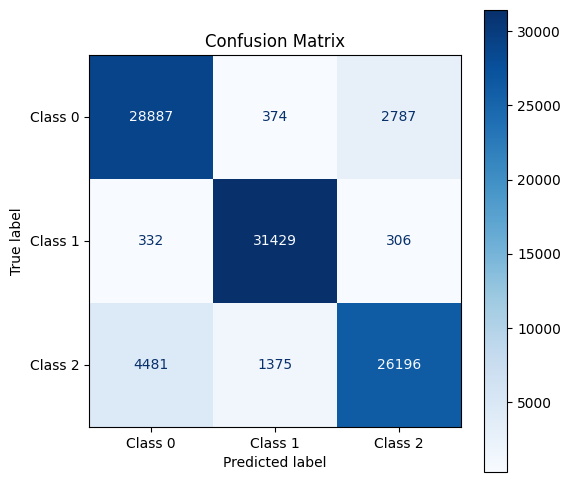

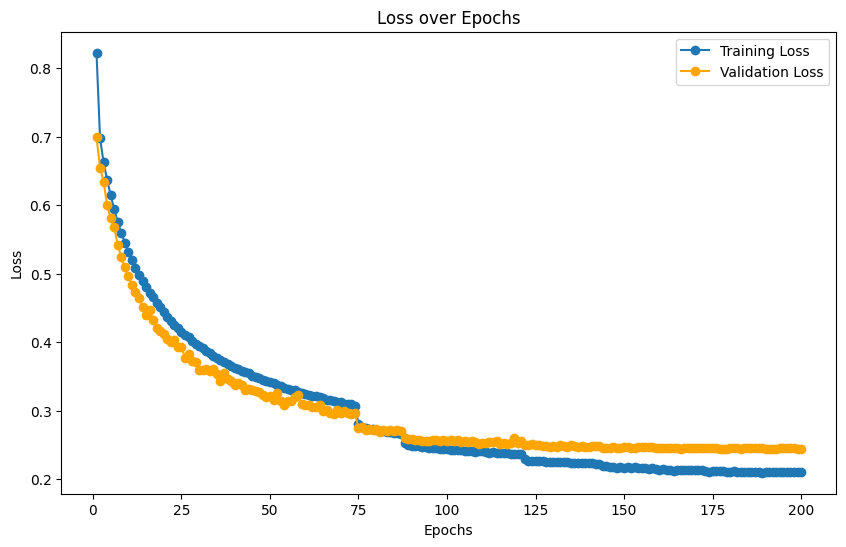

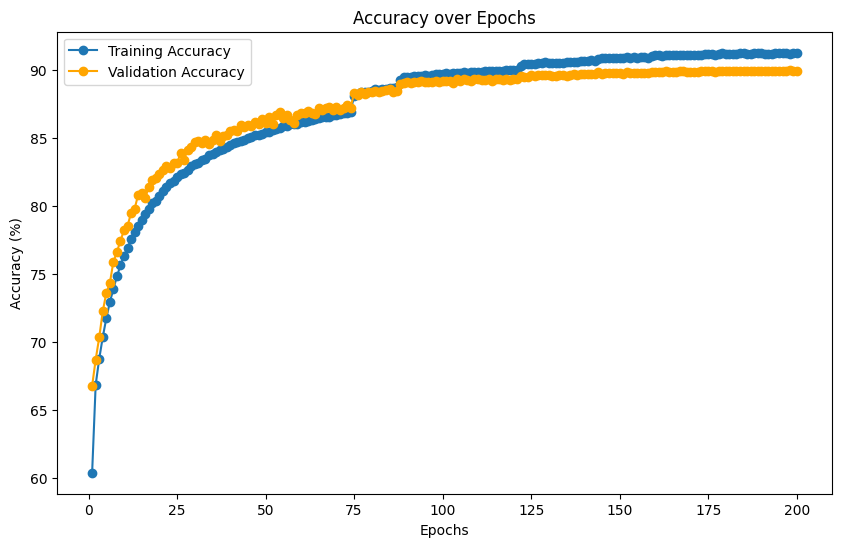

In [3]:
# Create DataLoader for PyTorch
def create_dataloader(X, y, batch_size):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

batch_size = 64
train_loader = create_dataloader(X_train, y_train, batch_size)
val_loader = create_dataloader(X_val, y_val, batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size)

# Step 3: Build the MLP model using PyTorch
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, 512)  # Increased neurons
        self.hidden2 = nn.Linear(512, 256)
        self.hidden3 = nn.Linear(256, 128)
        self.hidden4 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.3)  # Reduced dropout to prevent underfitting
        self.output = nn.Linear(64, 3)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = self.dropout(torch.relu(self.hidden2(x)))
        x = self.dropout(torch.relu(self.hidden3(x)))
        x = self.dropout(torch.relu(self.hidden4(x)))
        x = self.output(x)
        return x

# Calculate class weights
unique_classes, counts = torch.unique(y_resampled, return_counts=True)
class_weights = 1.0 / counts.float()
weights = class_weights[y_resampled]

# Define model, loss function with class weights, optimizer, and scheduler
input_size = X_train.shape[1]
model = MLP(input_size)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# Step 4: Train the model
num_epochs = 200
training_loss = []
validation_loss = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
        running_loss += loss.item()

    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    avg_loss = running_loss / len(train_loader)
    training_loss.append(avg_loss)

    # Evaluate on validation set
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_outputs = model(val_X)
            val_loss = criterion(val_outputs, val_y)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_y.size(0)
            val_correct += (val_predicted == val_y).sum().item()
            val_running_loss += val_loss.item()

    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)
    avg_val_loss = val_running_loss / len(val_loader)
    validation_loss.append(avg_val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    scheduler.step(avg_val_loss)  # Adjust learning rate based on validation loss

# Step 5: Evaluate on test data
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Generate the classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1", "Class 2"]))

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix with integer formatting
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Class 0", "Class 1", "Class 2"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format="d")  # Ensure integer formatting

plt.title("Confusion Matrix")
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_loss, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_loss, marker='o', label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', label='Validation Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


Below is the actual transformer

In [6]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/diabetes_binary_5050split_health_indicators_BRFSS2015.csv
/kaggle/input/diabetes_binary_health_indicators_BRFSS2015.csv
/kaggle/input/diabetes_012_health_indicators_BRFSS2015.csv


Dataset Shape: (253680, 21)
Target Distribution:
Diabetes_012
0.0    0.842412
2.0    0.139333
1.0    0.018255
Name: proportion, dtype: float64


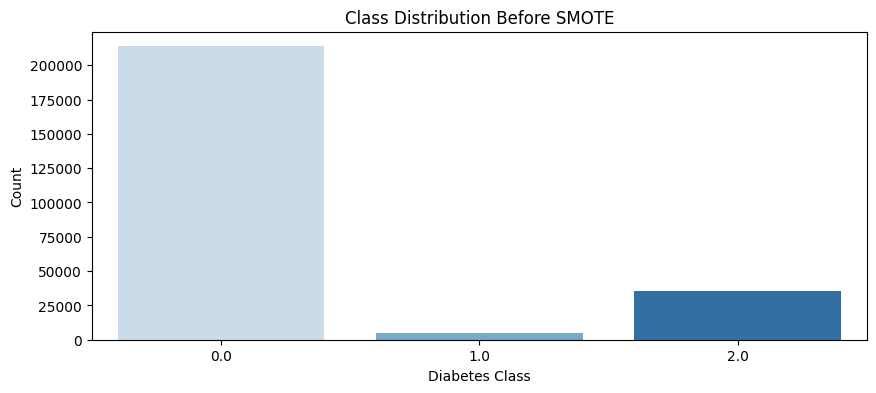

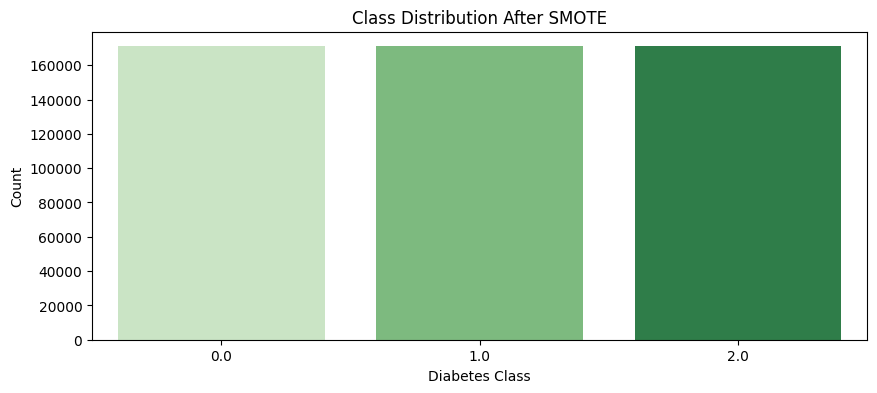

Using device: cuda


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from torch.utils.data import TensorDataset, DataLoader

# Set seed
np.random.seed(42)
torch.manual_seed(42)

# Load dataset
df = pd.read_csv('/kaggle/input/diabetes_012_health_indicators_BRFSS2015.csv')

X = df.drop('Diabetes_012', axis=1)
y = df['Diabetes_012']

print("Dataset Shape:", X.shape)
print("Target Distribution:")
print(y.value_counts(normalize=True))

#  PLOT: BEFORE SMOTE
plt.figure(figsize=(10, 4))
sns.countplot(x=y, palette="Blues")
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Diabetes Class")
plt.ylabel("Count")
plt.show()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

# APPLY SMOTE on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# PLOT: AFTER SMOTE
plt.figure(figsize=(10, 4))
sns.countplot(x=y_train_resampled, palette="Greens")
plt.title("Class Distribution After SMOTE")
plt.xlabel("Diabetes Class")
plt.ylabel("Count")
plt.show()

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train_resampled.values)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test.values)

# DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = min(64, len(X_train_tensor))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


## Adding SMOTE Technique into Tab Transformer

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from torch.utils.data import TensorDataset, DataLoader

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Load dataset
df = pd.read_csv('/kaggle/input/diabetes_012_health_indicators_BRFSS2015.csv')
# df = pd.read_csv('./diabetes_012_health_indicators_BRFSS2015.csv')

X = df.drop('Diabetes_012', axis=1)
y = df['Diabetes_012']

print("Dataset Shape:", X.shape)
print("Target Distribution:")
print(y.value_counts(normalize=True))

# Train-test split before SMOTE (apply SMOTE only on training data)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the resampled training and original test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train_resampled.values)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test.values)

# Wrap into PyTorch DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = min(64, len(X_train_tensor))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Dataset Shape: (253680, 21)
Target Distribution:
Diabetes_012
0.0    0.842412
2.0    0.139333
1.0    0.018255
Name: proportion, dtype: float64
Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Running Transformer Train Model ........!
Epoch [1/200], Train Loss: 0.9238, Train Acc: 0.5820, Val Loss: 0.8495, Val Acc: 0.6895
Epoch [10/200], Train Loss: 0.7064, Train Acc: 0.7510, Val Loss: 0.6348, Val Acc: 0.8066
Epoch [20/200], Train Loss: 0.6198, Train Acc: 0.8095, Val Loss: 0.6396, Val Acc: 0.7978
Epoch [30/200], Train Loss: 0.5761, Train Acc: 0.8367, Val Loss: 0.6198, Val Acc: 0.8067
Epoch [40/200], Train Loss: 0.5512, Train Acc: 0.8516, Val Loss: 0.6079, Val Acc: 0.8143
Epoch [50/200], Train Loss: 0.5348, Train Acc: 0.8612, Val Loss: 0.6201, Val Acc: 0.8090
Epoch [60/200], Train Loss: 0.5232, Train Acc: 0.8686, Val Loss: 0.6189, Val Acc: 0.8049
Epoch [70/200], Train Loss: 0.4974, Train Acc: 0.8839, Val Loss: 0.6228, Val Acc: 0.8051
Epoch [80/200], Train Loss: 0.4906, Train Acc: 0.8880, Val Loss: 0.6182, Val Acc: 0.8116
Epoch [90/200], Train Loss: 0.4800, Train Acc: 0.8942, Val Loss: 0.6184, Val Acc: 0.8095
Epoch [100/200], Train Loss: 0.4742, Train Acc: 0.8978, Val Loss: 0.6

<ipython-input-2-02aa19286d7c>:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_transformer_model.pth'))


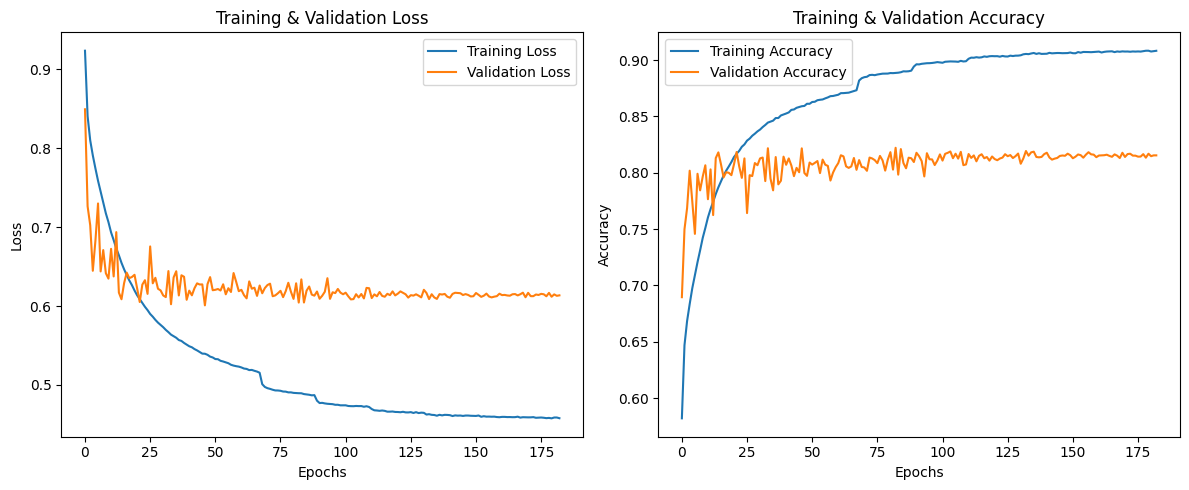


Classification Report:
              precision    recall  f1-score   support

Non-Diabetic       0.88      0.92      0.90     42741
Pre-Diabetic       0.02      0.02      0.02       926
    Diabetic       0.44      0.31      0.37      7069

    accuracy                           0.82     50736
   macro avg       0.45      0.42      0.43     50736
weighted avg       0.80      0.82      0.81     50736



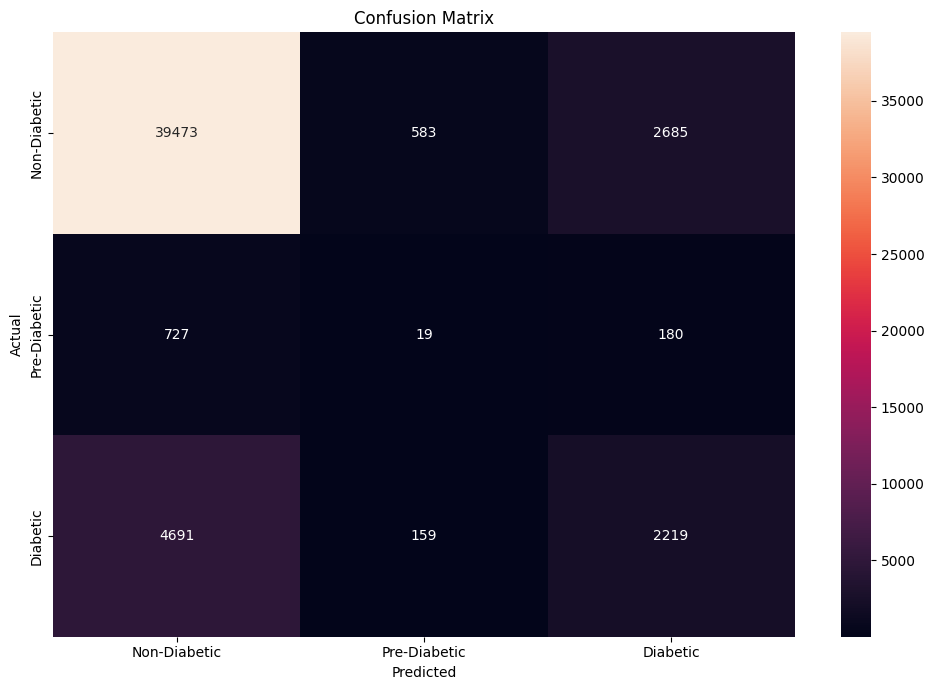

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformer Model
class TransformerTabular(nn.Module):
    def __init__(self, input_dim, num_classes=3, d_model=128, num_heads=4, num_layers=3, dim_feedforward=256, dropout=0.2):
        super(TransformerTabular, self).__init__()

        self.embedding = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU()
        )

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads,
                                                   dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.squeeze(1)
        return self.classifier(x)

# Training Function
def train_model(model, train_loader, test_loader, epochs=200, patience=100):
    print("Running Transformer Train Model ........!")
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_acc = 0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_train_loss, correct_train, total_train = 0, 0, 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == batch_y).sum().item()
            total_train += batch_y.size(0)

        train_loss = total_train_loss / len(train_loader)
        train_acc = correct_train / total_train

        # Validation
        model.eval()
        total_val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss = criterion(outputs, batch_y)
                total_val_loss += val_loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == batch_y).sum().item()
                total_val += batch_y.size(0)

        val_loss = total_val_loss / len(test_loader)
        val_acc = correct_val / total_val

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early Stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_transformer_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    model.load_state_dict(torch.load('best_transformer_model.pth'))
    return train_losses, val_losses, train_accuracies, val_accuracies

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    print("\nClassification Report:")
    class_names = ['Non-Diabetic', 'Pre-Diabetic', 'Diabetic']
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return cm

# Model setup
input_dim = X_train_tensor.shape[1]
model = TransformerTabular(input_dim).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

# Train Model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader)

# Plot Loss & Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate Model
confusion_matrix_result = evaluate_model(model, test_loader)

# Save Model
torch.save(model.state_dict(), 'diabetes_transformer_model_final.pth')


In [ ]:
## DNDF Model 

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = pd.read_csv(r'/kaggle/input/diabetes_012_health_indicators_BRFSS2015.csv')

# Separate features and labels
X = data.drop(columns=['Diabetes_012'])  # Replace 'Diabetes_012' with your label column name
y = data['Diabetes_012']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Convert labels to categorical for multi-class classification
y_train_res = tf.keras.utils.to_categorical(y_train_res, 3)
y_test = tf.keras.utils.to_categorical(y_test, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/200
16023/16023 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.5626 - loss: 0.9016 - val_accuracy: 0.6468 - val_loss: 0.7430 - learning_rate: 0.0010
Epoch 2/200
16023/16023 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.6694 - loss: 0.7464 - val_accuracy: 0.6275 - val_loss: 0.7850 - learning_rate: 0.0010
Epoch 3/200
16023/16023 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.7047 - loss: 0.6800 - val_accuracy: 0.6701 - val_loss: 0.7086 - learning_rate: 0.0010
Epoch 4/200
16023/16023 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.7252 - loss: 0.6394 - val_accuracy: 0.6541 - val_loss: 0.7391 - learning_rate: 0.0010
Epoch 5/200
16023/16023 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.7368 - loss: 0.6154 - val_accuracy: 0.6684 - val_loss: 0.7123 - learning_rate: 0.0010
Epoch 6/200
16013/16023 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7444 - loss: 0.5978
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
16023/16023 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/st

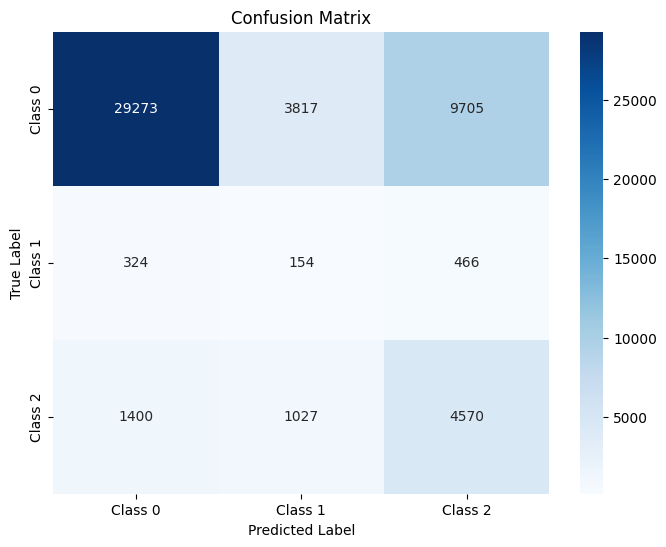

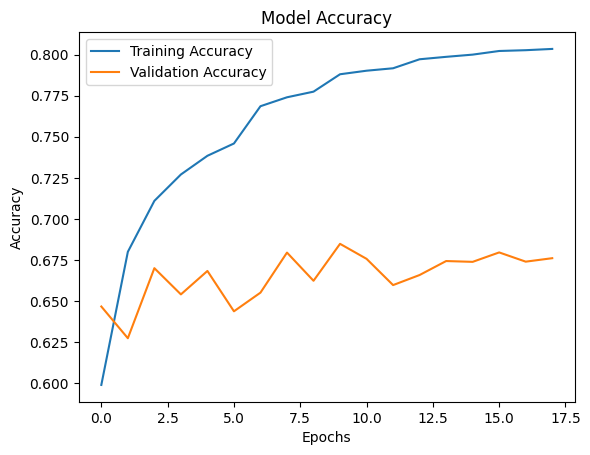

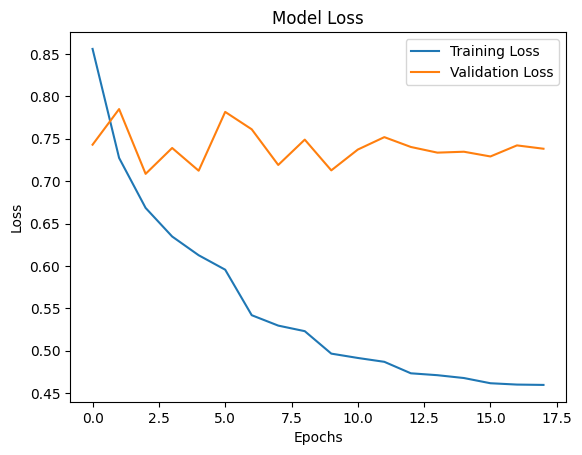

In [3]:

# Define the Neural Network component with increased complexity
def neural_network(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(512)(inputs)  # Increased neurons
    x = LeakyReLU(alpha=0.1)(x)  # Leaky ReLU activation
    x = Dropout(0.1)(x)  # Reduced dropout
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.1)(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.1)(x)
    x = Dense(64)(x)
    x = LeakyReLU(alpha=0.1)(x)
    return Model(inputs, x)

# Define the Decision Forest layer
def decision_forest_layer(x, num_trees=5, num_classes=3):
    tree_outputs = []
    for i in range(num_trees):
        tree_output = Dense(num_classes, activation='softmax', name=f'tree_{i+1}')(x)
        tree_outputs.append(tree_output)
    output = tf.keras.layers.Average()(tree_outputs)
    return output

# Build the Deep Neural Decision Forest Model
input_shape = (X_train.shape[1],)
nn_model = neural_network(input_shape)
decision_forest_output = decision_forest_layer(nn_model.output)

# Create the final model
model = Model(inputs=nn_model.input, outputs=decision_forest_output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks for learning rate reduction and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

# Train the model with increased epochs and batch size tuning
history = model.fit(X_train_res, y_train_res, validation_data=(X_test, y_test), 
                    epochs=200, batch_size=32, callbacks=[reduce_lr, early_stopping])  # Increased epochs and adjusted batch size

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=['Class 0', 'Class 1', 'Class 2'])
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plotting training and validation accuracy/loss

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()